In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import TranscriptionDataset, collate_fn
from Model.encoder_net import EncoderNet
from Model.decoder_net import DecoderNet
from train import train_transcriber
print(torch.__version__)
from tqdm import tqdm_notebook as tqdm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.4.0


In [2]:
# torch.backends.cudnn.enabled = False

### 1. Make Sure that the Encoder/Decoder and Work

In [3]:
def train_localizer_network():
    IMAGE_DIR = '../Data/FullData/Cropped_Images/'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    WORD_VEC_PATH = '../Data/FullData/Transcriptions/nutrition_vectors.npy'
    INDEX_TO_TERM_PATH = '../Data/FullData/Transcriptions/index_term_dict.npy'
    TERM_TO_INDEX_PATH = '../Data/FullData/Transcriptions/term_index_dict.npy'
    PATH_TO_MEAN_IMAGE = '../Data/FullData/512_512_mean.npy' 
    debug = not torch.cuda.is_available()
    
    train_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='train'
    )
    train_loader = DataLoader( 
        train_dataset, batch_size=16, shuffle=True,
        num_workers=16, collate_fn=collate_fn
    )
    
    dev_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='dev',
    )
    dev_loader = DataLoader(
        dev_dataset, batch_size=16, shuffle=True, 
        num_workers=16, collate_fn=collate_fn
    )
    
    
    config = {
        'keep_prob': 0.9995
    }
    learning_rate = 4.5e-4
    
    encoder = EncoderNet(config_params=config)
    word_vectors = train_dataset.get_word_vectors()
    embed_size = len(word_vectors[0])
    output_size = train_dataset.get_output_size()
    decoder = DecoderNet(word_vectors, output_size, embed_size)
    
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.SGD(
        filter(lambda p: p.requires_grad, parameters), 
        lr=learning_rate, momentum=0.9
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, [50, 100, 150],
        gamma=0.1
    )
    results = train_transcriber(
        encoder, decoder, optimizer, train_loader, dev_loader,
        train_dataset, dev_dataset, epochs=20, restore=False,
        scheduler=scheduler
    )
    return results

In [ ]:
train_losses, dev_losses, train_bleu, dev_bleu = train_localizer_network()


==== Performance Check === 
	 Train Loss =  4.914254188537598
	 Dev Loss =  5.750794380430191
	 Train BLEU =  0.0014341725
	 Dev BLEU =  0.001024409



==== Performance Check === 
	 Train Loss =  5.702629089355469
	 Dev Loss =  5.631033193497431
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714



==== Performance Check === 
	 Train Loss =  5.866418838500977
	 Dev Loss =  5.611763061039031
	 Train BLEU =  0.00061464537
	 Dev BLEU =  0.00061464537


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


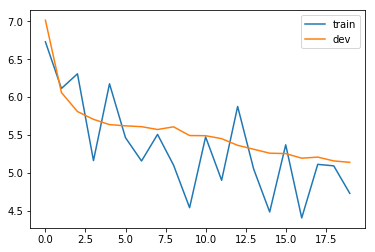

In [6]:
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()

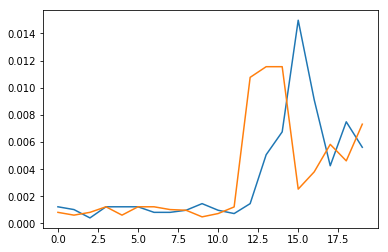

In [7]:
plt.plot(train_bleu)
plt.plot(dev_bleu)

In [ ]:
def ensure_all_data_is_available():
    import numpy as np
    data_path = '../Data/FullData/train_dev_test.npy'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    annotations = np.load(ANNOTATION_PATH).item()
    images = (
            np.load(data_path).item()['train'] + np.load(data_path).item()['dev'] + 
            np.load(data_path).item()['test']
    )
    bad = []
    for img in tqdm(images):
        num = img[:img.rfind('_')]
        nut = '1_' + num; ingr = '0_'+num
        if nut not in annotations or ingr not in annotations:
            bad.append(num)
    print(set(bad))

In [ ]:
# ensure_all_data_is_available()

In [36]:
a = torch.Tensor()
a = a.new_ones((2, 2, 10))
b = a.new_zeros((2, 10))

In [37]:
a.shape

torch.Size([2, 2, 10])

In [38]:
b.shape

torch.Size([2, 10])

In [41]:
b = b.expand(2, 2, 10)

In [44]:
c = torch.cat((a, b), -1)

In [45]:
c.shape

torch.Size([2, 2, 20])